In [ ]:
import pathlib

import cv2
import h5py
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import torch.fft
import torch.utils.data
import torchvision.transforms as T
import tqdm
from torchsummary import summary

from src.data import datamodule, dataset, transforms
from src.model import combiners

In [ ]:
def to_displayable(img, converted: int | None = cv2.COLOR_BGR2RGB) -> PIL.Image.Image:
    if converted is not None:
        img = cv2.cvtColor(img, converted)
    return PIL.Image.fromarray(np.clip(img.astype(np.uint8), 0, 255))


def showarray(img, converted: int | None = cv2.COLOR_BGR2RGB) -> None:
    display(to_displayable(img, converted))

In [ ]:
img_paths = list(pathlib.Path("./data/").glob("**/*.npy"))
len(img_paths)

792

In [ ]:
dat = dataset.BGREADataset(
    img_paths,
    transform=T.Compose(
        [
            transforms.EventMaskChannelRemover(),
            T.ToTensor(),
        ]
    ),
    augmenter=transforms.CompositeLightArtifactAugmenter(
        augmenters=[
            transforms.LensFlareAdder(1, 10, 1, 20, 0.6, 0.9, 0.2),
            transforms.VeilingGlareAdder(10, 150, 10, 150, 0.3),
            transforms.SunAdder(4, 25, 0.0, 0.5, 0.3, 0.8),
        ],
        probs=[0.9, 0.6, 0.15],
        fix_by_idx=True,
    ),
)
loader = torch.utils.data.DataLoader(
    dat,
    batch_size=4,
    num_workers=0,
    pin_memory=True,
    shuffle=False,
)

In [ ]:
def tensor_to_numpy_img(tensor: torch.Tensor) -> np.ndarray:
    tensor_np = tensor.detach().cpu().numpy()
    if tensor_np.ndim == 4:
        tensor_np = tensor_np.transpose(0, 2, 3, 1)
        tensor_np = np.concatenate(tensor_np, axis=1)  # BxHxWxC -> HxWxC
    elif tensor_np.ndim == 3:
        tensor_np = tensor_np.transpose(1, 2, 0)
    return (tensor_np * 255.0).astype(np.uint8)

In [ ]:
combiner = combiners.MaskedRemovalCombiner(
    binarize=True,
    yuv_interpolation=True,
    soft_factor=5,
)

In [ ]:
x, y = next(iter(loader))

x_comb = combiner(x, y[:, 3:4])

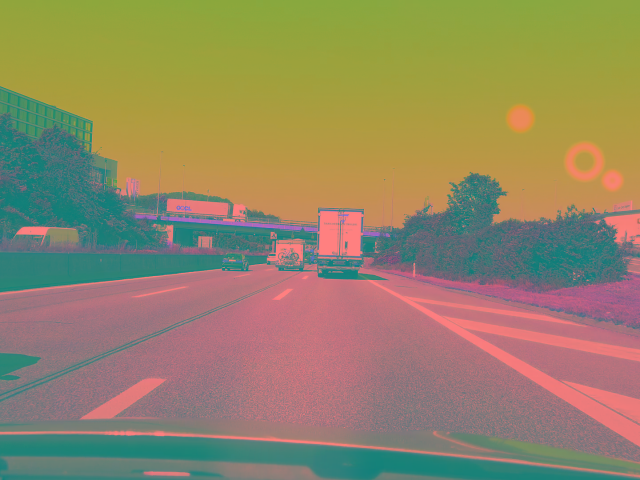

In [ ]:
arr = tensor_to_numpy_img(x[0])[..., :3]
arr_yuv = cv2.cvtColor(arr, cv2.COLOR_BGR2YUV)
showarray(arr_yuv, None)

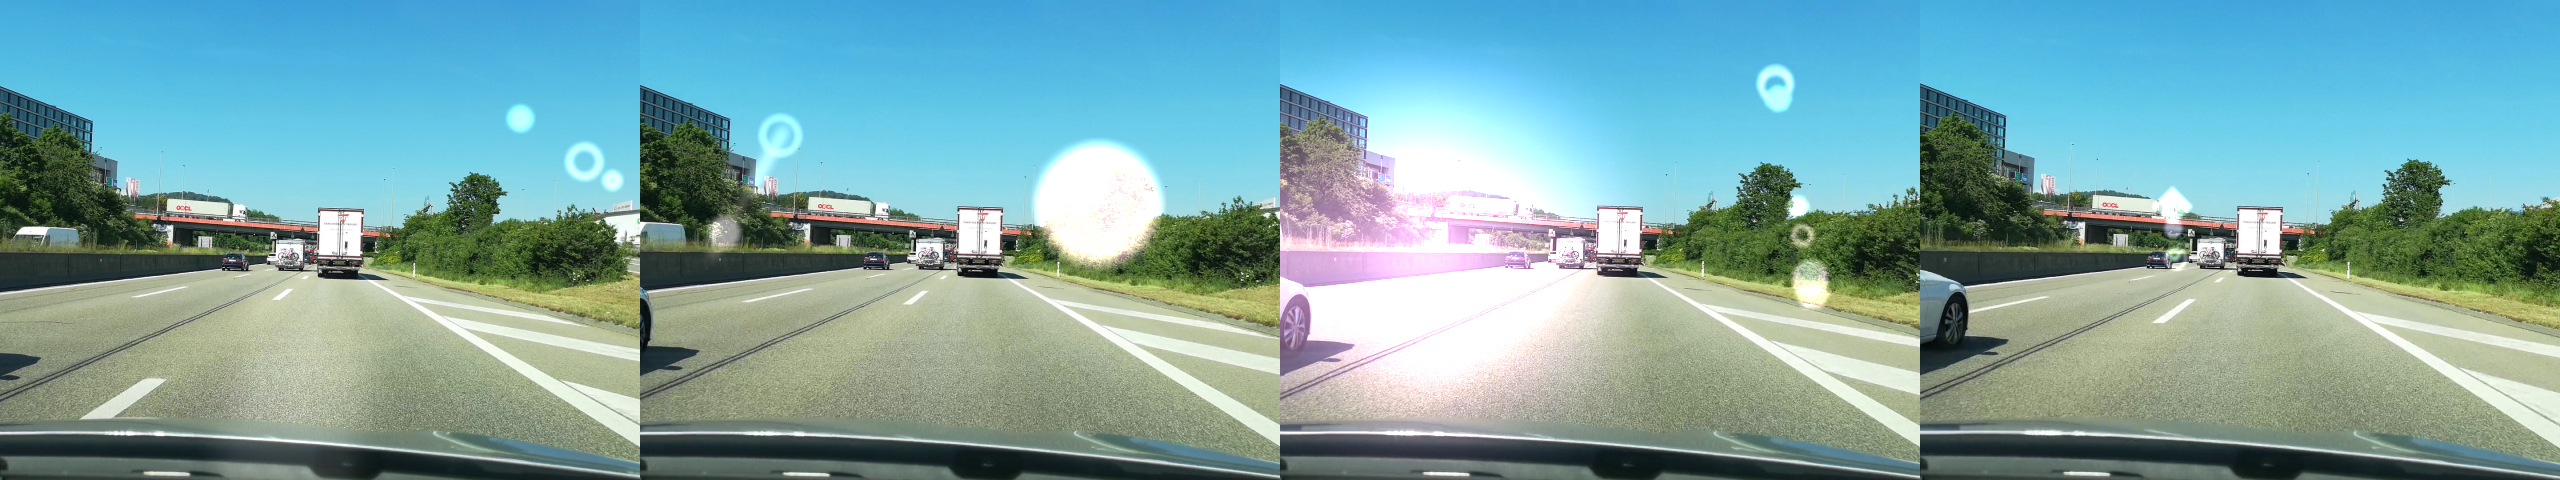

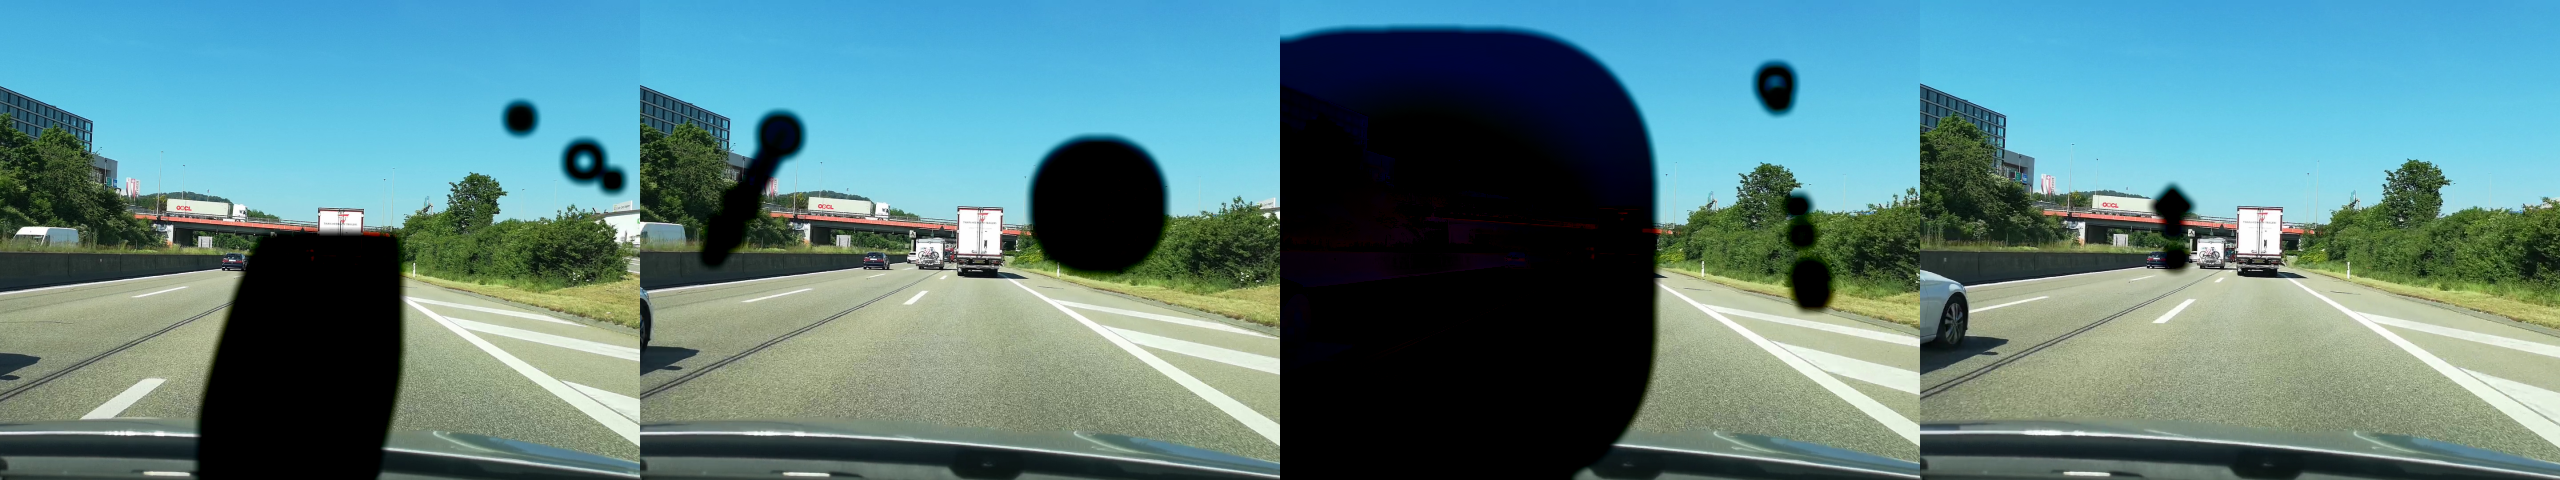

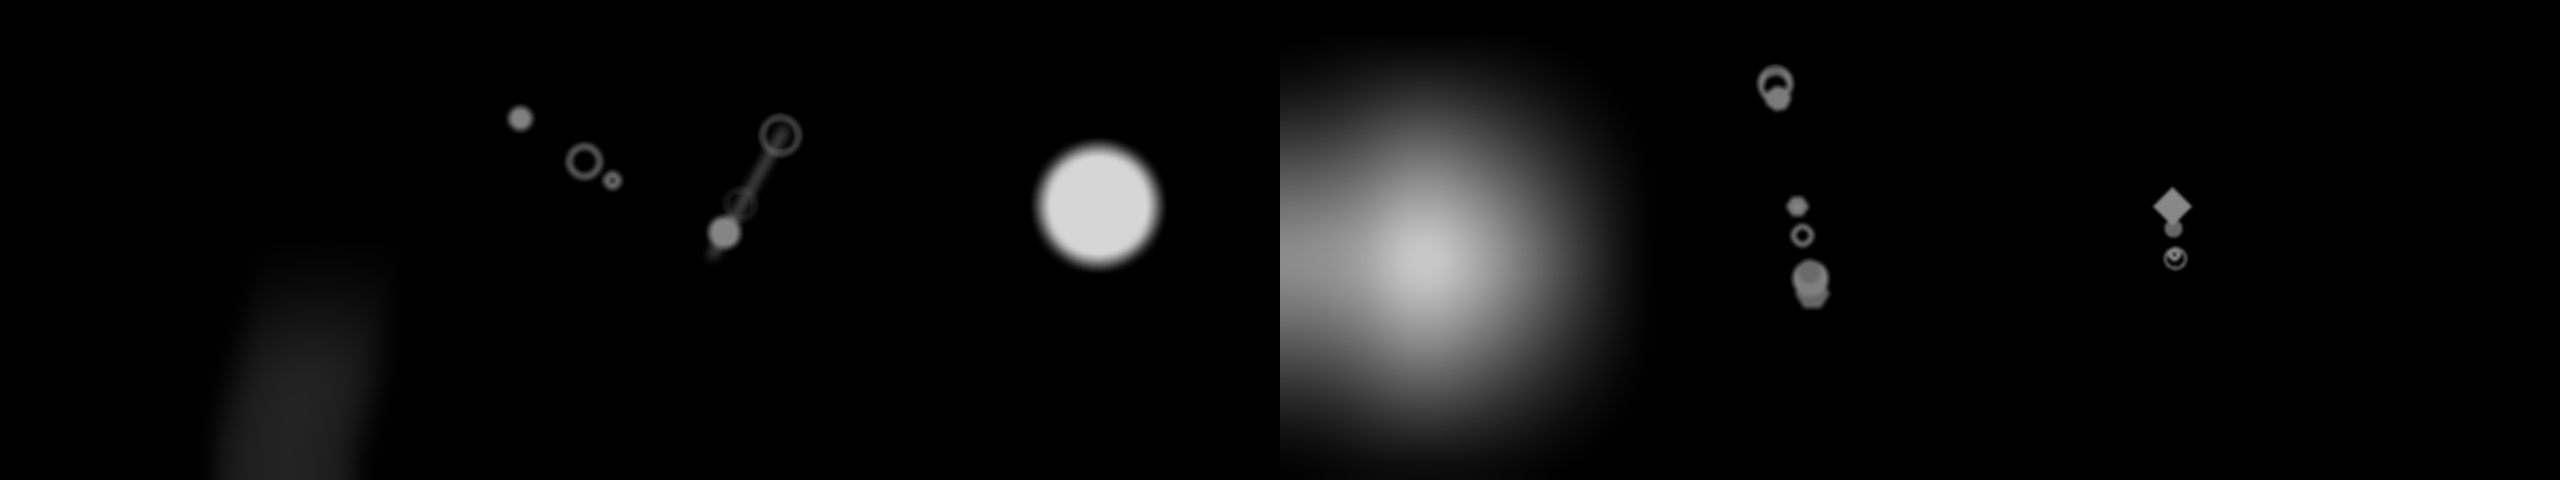

In [14]:
showarray(tensor_to_numpy_img(x))
showarray(tensor_to_numpy_img(x_comb)[..., :3], None)
showarray(tensor_to_numpy_img(y)[..., 3])